In [1]:
import ROOT as r
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
r.gROOT.SetBatch(1)

In [51]:
runs = {0:940, 1:942, 16:943, 17:944, 32:945, 33:947, 48:948, 49:949,
        50:950, 51:950, 34:953, 35:953, 18:954, 19:954, 2:955, 3:955,
        10:959, 11:960, 8:961, 9:961, 26:962, 24:965, 25:964, 42:966,
        40:968, 41:968, 59:970, 56:971, 57:971, 63:972, 62:973, 60:974,
        61:974, 47:975, 46:977, 44:978, 45:978, 31:979, 30:980, 28:981,
        29:981, 15:982, 14:984, 12:985, 13:985, 5:991, 4:992, 6:993,
        7:993, 21:994, 20:995, 22:997, 23:997, 37:998, 36:999, 38:1000,
        39:1000, 53:1001, 52:1002, 54:1003, 55:1003, 43:967, 58:969, 27:963
}
#last 3 may be wrong


fit_bounds = {0:[10e3, 80e3], 1:[10e3, 80e3], 16:[1e4, 5e4], 17:[2e4, 7e4], 32:[1e4, 6e4],
             33:[2e4,9e4], 48:[1e4,6e4], 49:[1e4,6e4], 50:[1e4, 7e4], 51:[0.8e4, 6e4],
             34:[1.8e4, 5e4], 35:[1.2e4, 4e4], 18:[15e3, 8e4], 19:[1e4, 5e4], 2:[1e4, 5e4],
              3:[1e4, 5e4], 10:[2e4,8e4], 11: [1e4, 5e4], 8:[1.5e4,6e4], 9:[2e4,8e4],
              26:[2e4,7e4], 24:[1.5e4,6e4], 25:[1e4,8e4], 42:[2e4,8e4], 40:[1e4,6e4], 
              41:[0.9e4,8e4], 59:[1e4,8e4], 56:[1e4,5e4], 57:[1e4,5e4], 63:[1e4,6e4], 62:[1e4,6e4],
              60:[1e4,6e4], 61:[1e4,4e4], 47:[1e4,4e4], 46:[1e4,6e4], 44:[1e4,4e4], 45:[1.2e4,5e4],
              31:[1e4,5e4], 30:[1e4,6e4], 28:[0.9e4,4e4], 29: [1.5e4,4e4], 15:[1e4,6e4], 14:[1e4,6e4],
              12:[1.5e4,5e4], 13:[1.2e4,5e4], 5:[1e4,4e4], 4:[1.5e4,6e4], 6:[1.5e4,6e4], 7:[0.5e4,5e4], 
              21:[1e4,5e4], 22:[0.9e4,5e4], 20:[1.5e4,5e4], 23:[8e3, 3e4], 37:[1e4,6e4], 36:[1e4,8e4], 
              38:[1e4,4e4], 39:[9e3,4e4], 53:[1e4,5e4], 52:[5e3, 4e4], 54:[6e3,4e4], 55:[0.9e4,6e4], 
              43:[1e4,7e4], 58:[1e4,6e4], 27:[8e3,6e4]}


In [52]:
for i in range(64):
    if i not in runs.keys():
        print(f'channel {i} not in runs list')
    if i not in fit_bounds.keys():
        print(f'channel {i} not in fit bounds')

In [53]:
# check that each run actually has peak

default = r.TChain('t')
name_def = '/eos/experiment/milliqan/trees/v35/1900/MilliQan_Run1900.*_v35.root'
default.Add(name_def)

outputFile = 'sourceCalibrationsDebug2.pdf'
outputFits = 'sourceFitsDebug.pdf'

if os.path.exists(outputFile):
    os.remove(outputFile)
if os.path.exists(outputFits):
    os.remove(outputFits)

c1 = r.TCanvas("c1", "c1", 800, 600)
c2 = r.TCanvas("c2", "c2", 800, 600)

f1 = r.TF1('f1', 'gaus', 5000, 80000)

v_mean = []
v_sigma = []
v_meanErr = []
v_sigmaErr = []

processed = 0
for i, (key, val) in enumerate(sorted(runs.items())):
    #if key!= 16: continue
    c1.cd()
    c1.Clear()
    c2.Clear()
    
    print(i, key, val)
    #if key!=5 and key!=22: continue

    processed += 1
    #if i > 4: break
    
    if val < 1000:
        fname = f'/eos/experiment/milliqan/trees/v35/900/MilliQan_Run{val}.*.root'
    elif val >= 1000:
        fname = f'/eos/experiment/milliqan/trees/v35/1000/MilliQan_Run{val}.*.root'
    fin = r.TChain('t')
    fin.Add(fname)
    print("Number of entries", fin.GetEntries())

    fin.Draw('area>>h1(500, 0, 100000)', f'chan=={key} && ipulse==0 && !pickupFlag && height>100')
    h1 = r.gDirectory.Get("h1")

    default.Draw('area>>h2(500, 0, 100000)', f'chan=={key} && ipulse==0 && !pickupFlag && height>100')
    h2 = r.gDirectory.Get('h2')

    c1.cd()
    h1.SetTitle(f'Source vs Default Run Channel {key};Area;Pulses')
    h1.Draw()
    h2.SetLineColor(r.kRed)
    h2.Draw("same")

    l1 = r.TLegend(0.6, 0.5, 0.8, 0.6)
    l1.SetBorderSize(0)
    l1.AddEntry(h1, f'Source Run {val}', 'l')
    l1.AddEntry(h2, f'Default Run 1900', 'l')
    l1.Draw("same")

    c2.cd()
    h1.Draw()
    h1.Fit(f1, 'S', '', fit_bounds[key][0], fit_bounds[key][1])

    mean = round(f1.GetParameter(1), 2)
    sigma = round(f1.GetParameter(2), 2)
    meanErr = round(f1.GetParError(1), 2)
    sigmaErr = round(f1.GetParError(2), 2)

    v_mean.append(mean)
    v_sigma.append(sigma)
    v_meanErr.append(meanErr)
    v_sigmaErr.append(sigmaErr)

    maxy = h1.GetMaximum()
    textY = maxy - maxy*0.2

    t1 = r.TLatex()
    t1.SetNDC()
    t1.DrawLatex(0.6, 0.5, f'#mu={mean}#pm{meanErr}')

    t2 = r.TLatex()
    t2.SetNDC()
    t2.DrawLatex(0.6, 0.6, 'Channel 16')
    
    if processed==1:
        c1.Print(f'{outputFile}(')
        c2.Print(f'{outputFits}(')
    elif processed==64:
        c1.Print(f'{outputFile})')
        c2.Print(f'{outputFits})')
    else:
        c1.Print(f'{outputFile}')
        c2.Print(f'{outputFits}')
    

0 0 940
Number of entries 29000
1 1 942
Number of entries 23552
2 2 955
Number of entries 5171
3 3 955
Number of entries 5171
4 4 992
Number of entries 4421
5 5 991
Number of entries 5134
6 6 993
Number of entries 7321
7 7 993
Number of entries 7321
8 8 961
Number of entries 18079
9 9 961
Number of entries 18079
10 10 959
Number of entries 13777
11 11 960
Number of entries 6286
12 12 985
Number of entries 5315
13 13 985
Number of entries 5315
14 14 984
Number of entries 5167
15 15 982
Number of entries 5522
16 16 943
Number of entries 22901
17 17 944
Number of entries 27388
18 18 954
Number of entries 5603
19 19 954
Number of entries 5603
20 20 995
Number of entries 5405
21 21 994
Number of entries 5218
22 22 997
Number of entries 6607
23 23 997
Number of entries 6607
24 24 965
Number of entries 5210
25 25 964
Number of entries 850
26 26 962
Number of entries 5581
27 27 963
Number of entries 5108
28 28 981
Number of entries 8368
29 29 981
Number of entries 8368
30 30 980
Number of entr

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2
Info in <TCanvas::Print>: Current canvas added to pdf file sourceCalibrationsDebug2.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file sourceFitsDebug.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file sourceCalibrationsDebug2.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file sourceFitsDebug.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file sourceCalibrationsDebug2.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file sourceFitsDebug.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file sourceCalibrationsDebug2.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file sourceFitsDebug.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file sourceCalibrationsDebug2.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file sourceFitsDebug.pdf
Info in <TCanvas::Print>:

Info in <TCanvas::Print>: png file sourceComparrisonChan16.png has been created


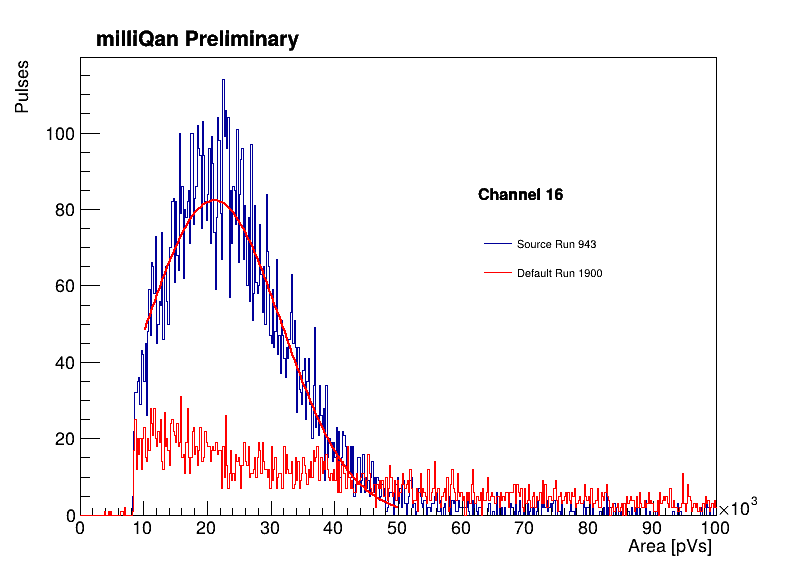

In [48]:
h = c1.GetPrimitive('h1')
h.SetTitle(';Area [pVs];Pulses')
c1.cd()
t2 = r.TLatex()
t2.SetNDC()
t2.SetTextSize(0.03)
t2.DrawLatex(0.6, 0.65, 'Channel 16')
expName = r.TLatex()
expName.SetNDC()
expName.SetTextSize(0.04);
expName.DrawLatex(0.12, 0.92, "milliQan Preliminary");
c1.Draw()
c1.SaveAs('sourceComparrisonChan16.png')

Info in <TCanvas::Print>: png file channel16SourceFit.png has been created


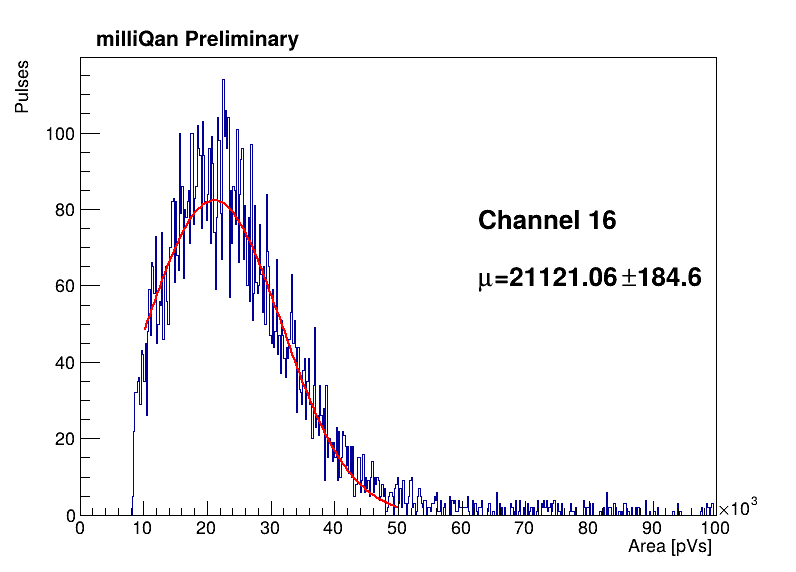

In [47]:
h = c2.GetPrimitive('h1')
h.SetTitle(';Area [pVs];Pulses')
c2.Draw()
c2.cd()
expName = r.TLatex()
expName.SetNDC()
expName.SetTextSize(0.04);
expName.DrawLatex(0.12, 0.92, "milliQan Preliminary");
c2.SaveAs('channel16SourceFit.png')


In [54]:
h_mean = r.TGraphErrors()
h_sigma = r.TGraphErrors()

for i, (m, mE, s, sE) in enumerate(zip(v_mean, v_meanErr, v_sigma, v_sigmaErr)):
    h_mean.SetPoint(i, i, m)
    h_mean.SetPointError(i, 0, mE)
    h_sigma.SetPoint(i, i, s)
    h_sigma.SetPointError(i, 0, sE)

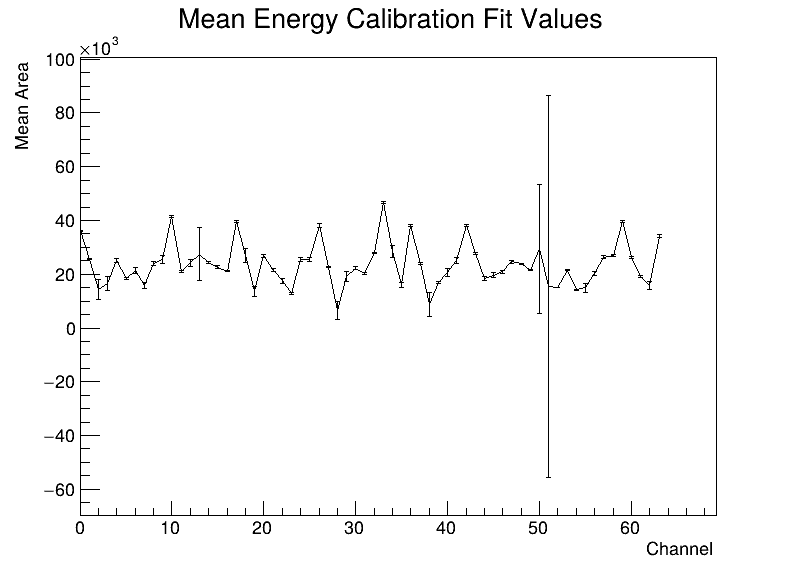

In [55]:
c1.Clear()
h_mean.Draw()
h_mean.SetTitle('Mean Energy Calibration Fit Values;Channel;Mean Area')
c1.Draw()

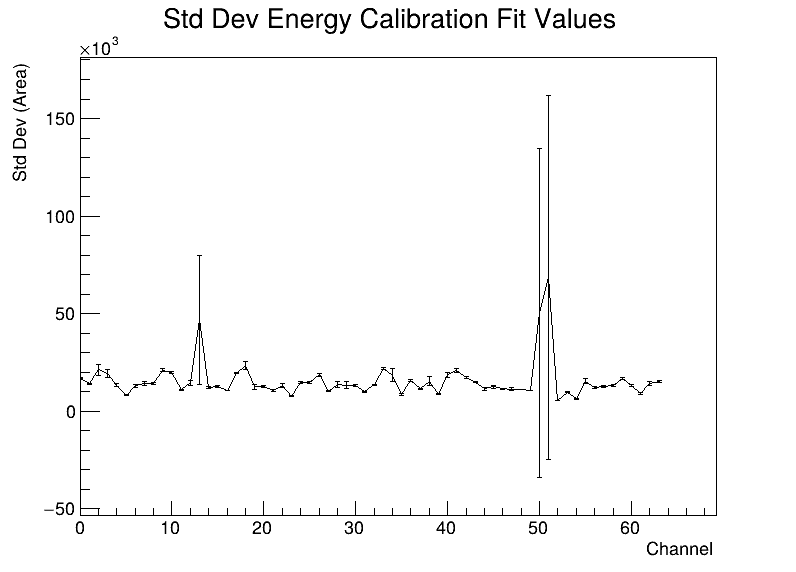

In [56]:
c1.Clear()
h_sigma.Draw()
h_sigma.SetTitle('Std Dev Energy Calibration Fit Values;Channel;Std Dev (Area)')
c1.Draw()

In [58]:
df = pd.DataFrame({"mean": v_mean, "meanErr": v_meanErr, "sigma": v_sigma, "sigmaErr": v_sigmaErr})
df

,mean,meanErr,sigma,sigmaErr
0,36155.57,172.31,16981.93,156.49
1,25564.14,220.63,14130.98,187.95
2,14378.64,3745.15,21242.52,2810.46
3,16462.60,2536.69,19475.00,2031.16
4,25218.59,791.47,13439.44,636.64
...,...,...,...,...
59,39475.73,403.83,16785.99,432.59
60,26333.63,404.88,13319.61,402.88
61,19104.51,446.17,8970.46,427.83
62,15762.80,1390.63,14443.36,979.52


In [60]:
df_goodVals = df.drop([25, 50, 51])

meanVal = round(df_goodVals['mean'].mean(), 2)
meanErrVal = np.sqrt((df_goodVals['meanErr']**2).sum()) / len(df_goodVals)
sigmaVal = round(df_goodVals['sigma'].mean(), 2)
sigmaErrVal = np.sqrt((df_goodVals['sigmaErr']**2).sum()) / len(df_goodVals)

In [1]:
meanVal

NameError: name 'meanVal' is not defined

In [61]:
df.loc[[25, 50, 51], 'mean'] = meanVal
df.loc[[25, 50, 51], 'meanErr'] = meanErrVal
df.loc[[25, 50, 51], 'sigma'] = sigmaVal
df.loc[[25, 50, 51], 'sigmaErr'] = sigmaErrVal

In [62]:
df

,mean,meanErr,sigma,sigmaErr
0,36155.57,172.31,16981.93,156.49
1,25564.14,220.63,14130.98,187.95
2,14378.64,3745.15,21242.52,2810.46
3,16462.60,2536.69,19475.00,2031.16
4,25218.59,791.47,13439.44,636.64
...,...,...,...,...
59,39475.73,403.83,16785.99,432.59
60,26333.63,404.88,13319.61,402.88
61,19104.51,446.17,8970.46,427.83
62,15762.80,1390.63,14443.36,979.52


In [63]:
df.to_json('energy_calibrations.json', orient='records')

In [64]:
f_cal = open('../../configuration/barConfigs/configRun1296_present.json')
calibrations = json.load(f_cal)['speAreas']
calibrations

calibrations[24] = calibrations[78]
calibrations[25] = calibrations[79]

In [65]:
df['sPE'] = calibrations[:64]

df['energyNPE'] = round(df['mean']/df['sPE'], 2)
df

,mean,meanErr,sigma,sigmaErr,sPE,energyNPE
0,36155.57,172.31,16981.93,156.49,3732.70,9.69
1,25564.14,220.63,14130.98,187.95,3771.71,6.78
2,14378.64,3745.15,21242.52,2810.46,2888.98,4.98
3,16462.60,2536.69,19475.00,2031.16,3690.51,4.46
4,25218.59,791.47,13439.44,636.64,3210.13,7.86
...,...,...,...,...,...,...
59,39475.73,403.83,16785.99,432.59,4763.02,8.29
60,26333.63,404.88,13319.61,402.88,3183.72,8.27
61,19104.51,446.17,8970.46,427.83,2513.53,7.60
62,15762.80,1390.63,14443.36,979.52,3099.01,5.09


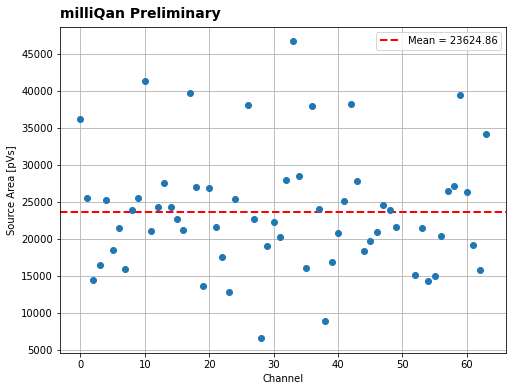

In [120]:
#df_cleaned = df.drop([25, 50, 51])

fig, ax = plt.subplots(figsize=(8,6))

ax.errorbar(df_cleaned.index, df_cleaned['mean'], yerr=df_cleaned['meanErr']/df_cleaned['sPE'], fmt='o')
#fig.title("NPE of Energy Calibration")
ax.set_ylabel("Source Area [pVs]")
ax.set_xlabel("Channel")
ax.grid(True)

bbox = ax.get_position()
x_left = bbox.x0  # Left edge of the axes
y_top = bbox.y1   # Top edge of the axes

# Add a left-aligned title just above the top margin
fig.text(x_left, y_top + 0.02, "milliQan Preliminary", fontsize=14, fontweight='bold', ha='left')

mean_value = df_cleaned['mean'].mean()
plt.axhline(mean_value, color='r', linestyle='dashed', linewidth=2, label=f'Mean = {mean_value:.2f}')


plt.legend()
plt.savefig('sourceArea.png', dpi=300, bbox_inches='tight')

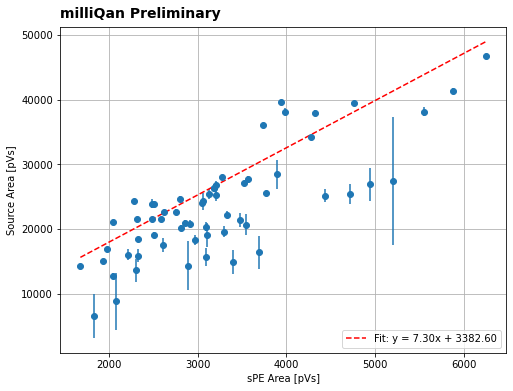

In [116]:
fig, ax = plt.subplots(figsize=(8,6))

ax.errorbar(df_cleaned['sPE'], df_cleaned['mean'], yerr=df_cleaned['meanErr'], fmt='o')
#plt.title("sPE vs Source Area")
ax.set_ylabel("Source Area [pVs]")
ax.set_xlabel("sPE Area [pVs]")
ax.grid(True)

bbox = ax.get_position()
x_left = bbox.x0  # Left edge of the axes
y_top = bbox.y1   # Top edge of the axes

coeffs = np.polyfit(df_cleaned['sPE'], df_cleaned['mean'], deg=1, w=1/df_cleaned['meanErr'])  # Linear fit (degree=1)
fit_fn = np.poly1d(coeffs)

x_fit = np.linspace(min(df_cleaned['sPE']), max(df_cleaned['sPE']), 100)  # Smooth x range
plt.plot(x_fit, fit_fn(x_fit), '--r', label=f"Fit: y = {coeffs[0]:.2f}x + {coeffs[1]:.2f}")

# Add a left-aligned title just above the top margin
fig.text(x_left, y_top + 0.02, "milliQan Preliminary", fontsize=14, fontweight='bold', ha='left')

plt.legend(loc='lower right')
plt.savefig('sourceVsSPEArea.png', dpi=300, bbox_inches='tight')

In [56]:
print(df['energyNPE'].to_list())

[9.69, 6.78, 4.98, 4.46, 7.86, 7.92, 6.17, 6.83, 9.64, 5.41, 7.05, 7.36, 7.95, 5.29, 10.67, 8.22, 10.34, 10.08, 5.45, 5.93, 8.37, 8.32, 6.73, 6.23, 8.14, 8.71, 6.88, 8.66, 3.58, 6.13, 6.68, 7.19, 8.56, 7.47, 7.33, 7.25, 8.8, 7.89, 4.26, 8.52, 5.85, 5.67, 9.57, 7.79, 6.19, 5.96, 7.17, 8.78, 9.52, 8.66, 6.67, 5.99, 7.79, 9.28, 8.5, 4.39, 6.58, 8.29, 7.7, 8.29, 8.27, 7.6, 5.09, 7.99]


In [108]:
f_cal = open('../../configuration/barConfigs/configRun1296_present.json')
cals = json.load(f_cal)

df = pd.DataFrame({
    "timingCalibrations": cals["timingCalibrations"],
    "speAreas": cals["speAreas"],
    'pedestals':cals['pedestals']
    
})

df = df.drop([24, 25, 64, 65, 66, 67, 76, 77])

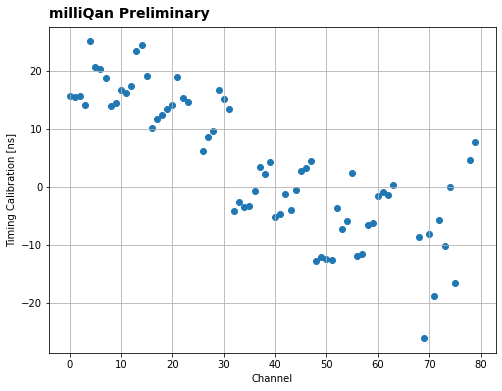

In [121]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(df.index, df['timingCalibrations'])
#plt.title("sPE vs Source Area")
ax.set_xlabel("Channel")
ax.set_ylabel("Timing Calibration [ns]")
ax.grid(True)

bbox = ax.get_position()
x_left = bbox.x0  # Left edge of the axes
y_top = bbox.y1   # Top edge of the axes

# Add a left-aligned title just above the top margin
fig.text(x_left, y_top + 0.02, "milliQan Preliminary", fontsize=14, fontweight='bold', ha='left')

#plt.legend(loc='lower right')
plt.savefig('timingCalibrations.png', dpi=300, bbox_inches='tight')

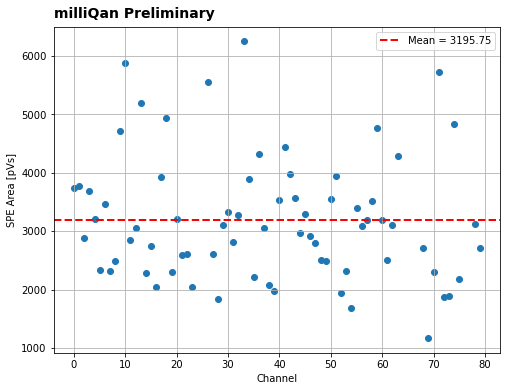

In [122]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(df.index, df['speAreas'])
#plt.title("sPE vs Source Area")
ax.set_ylabel("SPE Area [pVs]")
ax.set_xlabel("Channel")
ax.grid(True)

bbox = ax.get_position()
x_left = bbox.x0  # Left edge of the axes
y_top = bbox.y1   # Top edge of the axes

# Add a left-aligned title just above the top margin
fig.text(x_left, y_top + 0.02, "milliQan Preliminary", fontsize=14, fontweight='bold', ha='left')

mean_value = df['speAreas'].mean()
plt.axhline(mean_value, color='r', linestyle='dashed', linewidth=2, label=f'Mean = {mean_value:.2f}')

plt.legend()
plt.savefig('speCalibrations.png', dpi=300, bbox_inches='tight')

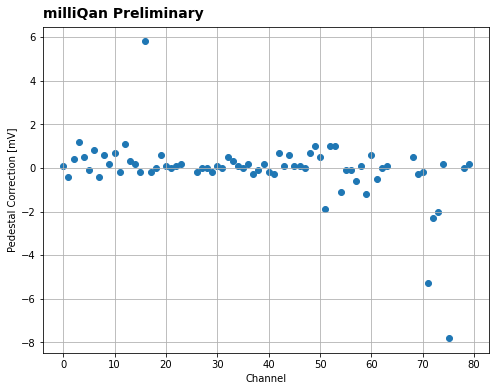

In [123]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(df.index, df['pedestals'])
#plt.title("sPE vs Source Area")
ax.set_xlabel("Channel")
ax.set_ylabel("Pedestal Correction [mV]")
ax.grid(True)

bbox = ax.get_position()
x_left = bbox.x0  # Left edge of the axes
y_top = bbox.y1   # Top edge of the axes

# Add a left-aligned title just above the top margin
fig.text(x_left, y_top + 0.02, "milliQan Preliminary", fontsize=14, fontweight='bold', ha='left')

#plt.legend(loc='lower right')
plt.savefig('pedestalCorrections.png', dpi=300, bbox_inches='tight')

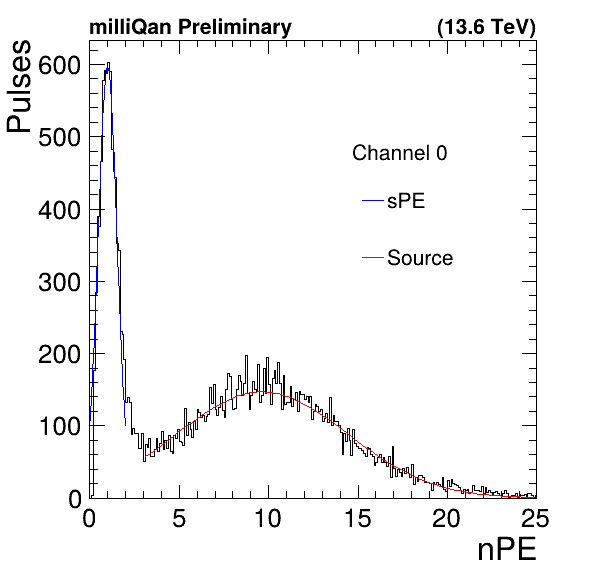

In [2]:
import cmsstyle as cms
#make nice plot of spe and source peaks
#channel 0

mychain = r.TChain('t')
mychain.Add('/eos/experiment/milliqan/trees/v35/900/MilliQan_Run940.*.root')
mychain.GetEntries()

c1 = cms.cmsCanvas('c1',0,100e3,1,200,"Area [pVs]","Pulses",iPos=0, square=True)


In [10]:
mychain.Draw("nPE>>h1(125, 0, 25", "ipulse==0 && !pickupFlag && chan==0")
h1 = r.gPad.GetPrimitive("h1")
#h2 = h1.Clone()

In [30]:
c1.Clear()
r.gStyle.SetOptFit(0)
h1.Sumw2(False)  # Disable automatic sqrt(N) errors
h1.SetBinErrorOption(r.TH1.kPoisson)
h1.SetLineColor(r.kBlack)
h1.GetXaxis().SetTitle('nPE')
h1.GetYaxis().SetTitle('Pulses')

r.gPad.SetLeftMargin(0.15)
r.gPad.SetRightMargin(0.1)

f1 = r.TF1('f1', 'gaus', 0, 2)
f2 = r.TF1('f2', 'gaus', 3, 25)

f1.SetLineColor(r.kBlue)


h1.Fit(f1, 'MRL', '', 0.3,1.5)
h1.Fit(f2, 'MRL', '', 3, 25)

r.gPad.SetLeftMargin(0.18)
h1.GetXaxis().SetTitleOffset(1)
h1.GetYaxis().SetTitleOffset(1.5)

h1.Draw("E")
f1.Draw("same")
f2.Draw("same")

expName = r.TLatex()
expName.SetNDC()
expName.SetTextSize(0.04);
expName.DrawLatex(0.19, 0.94, "milliQan Preliminary");

textRun = r.TLatex()
textRun.SetNDC()
textRun.SetTextSize(0.04)
textRun.SetTextAlign(31)
textRun.DrawLatex(0.9, 0.94, "(13.6 TeV)");

channelInfo = r.TLatex()
channelInfo.SetTextSize(0.04)
channelInfo.SetTextFont(42)
channelInfo.DrawLatexNDC(0.59, 0.72, 'Channel 0')

l1 = r.TLegend(0.6, 0.5, 0.8, 0.7)
l1.AddEntry(f1, 'sPE', 'l')
l1.AddEntry(f2, 'Source', 'l')
l1.Draw()

c1.Draw()

 FCN=0.717161 FROM HESSE     STATUS=OK             16 CALLS         122 TOTAL
                     EDM=8.46775e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.21391e+03   2.18295e+01   2.47684e-03  -2.01873e-05
   2  Mean         9.62270e-01   1.30945e-02   1.45083e-06   7.73053e-02
   3  Sigma        4.76740e-01   1.56659e-02   1.25436e-06  -2.78252e-02
                               ERR DEF= 0.5
 FCN=145.066 FROM HESSE     STATUS=OK             16 CALLS          97 TOTAL
                     EDM=2.1359e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.93188e+02   2.82249e+00   3.79222e-03   1.67231e-04
   2  Mean         9.64087e+00   5.48939e-02   7.43110e-05   7

Info in <TCanvas::Print>: png file sourceFitChannel0.png has been created


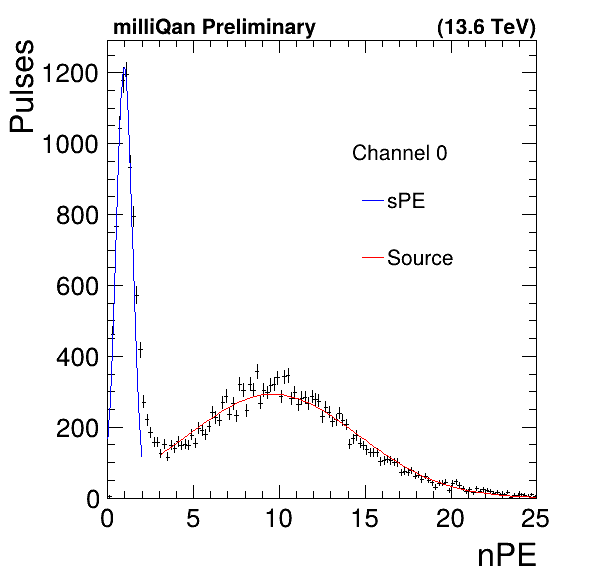

In [31]:
c1.Draw()
c1.SaveAs('sourceFitChannel0.png')